In [83]:
import numpy as np 
import pandas as pd  
import torch
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import torch.nn.functional as F 

data_dir = './data'

In [84]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import resnet50 , mobilenet_v2

In [85]:
class CNFG:
    epochs =20                             
    lr = 0.001                             
    batch_size = 256              
    img_size = 224
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cpu


In [86]:
data_transform = T.Compose([
                             T.Resize(size=(CNFG.img_size,CNFG.img_size)), # Resizing the image to be 224 by 224
                            #  T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                            #  T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
                            
])

In [87]:
data = datasets.ImageFolder(data_dir,       
                    transform=data_transform)
total_count = len(data) 
total_count

150

In [88]:
train_count = int(0.6 * total_count) 
valid_count = int(0.3 * total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))  
print("Train data: {} images".format(len(train_data))) 
print("Validation data: {} images".format(len(val_data))) 
print("Test data: {} images".format(len(test_data)))

Train data: 90 images
Validation data: 45 images
Test data: 15 images


In [89]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [90]:
train_data.dataset.classes

['arabic', 'chinese', 'indian', 'japanese']

In [91]:
train_data

In [92]:
trainloader = DataLoader(train_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))  
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data,batch_size=CNFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:1
No. of Total examples:90
No. of batches in validationloader:1
No. of Total examples:45
No. of batches in testloader:1
No. of Total examples:15


In [93]:
trainloader

In [94]:
from torch import nn
import torch.nn.functional as F
# import timm # PyTorch Image Models

model = mobilenet_v2(pretrained=True) #load pretrained model

In [95]:
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [96]:
#Updating the pretrained model:
for param in model.parameters():
    param.requires_grad=True

In [97]:
model.fc = nn.Linear(in_features=2048,out_features = 4, bias=True)

In [98]:
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [99]:
from torchsummary import  summary
model.to(device)# move the model to GPU
summary(model,input_size=(3,224,224))

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─ConvNormActivation: 2-1                --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─ReLU6: 3-3                        --
|    └─InvertedResidual: 2-2                  --
|    |    └─Sequential: 3-4                   896
|    └─InvertedResidual: 2-3                  --
|    |    └─Sequential: 3-5                   5,136
|    └─InvertedResidual: 2-4                  --
|    |    └─Sequential: 3-6                   8,832
|    └─InvertedResidual: 2-5                  --
|    |    └─Sequential: 3-7                   10,000
|    └─InvertedResidual: 2-6                  --
|    |    └─Sequential: 3-8                   14,848
|    └─InvertedResidual: 2-7                  --
|    |    └─Sequential: 3-9                   14,848
|    └─InvertedResidual: 2-8                  --
|    |    └─Sequential: 3-10                

Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─ConvNormActivation: 2-1                --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─ReLU6: 3-3                        --
|    └─InvertedResidual: 2-2                  --
|    |    └─Sequential: 3-4                   896
|    └─InvertedResidual: 2-3                  --
|    |    └─Sequential: 3-5                   5,136
|    └─InvertedResidual: 2-4                  --
|    |    └─Sequential: 3-6                   8,832
|    └─InvertedResidual: 2-5                  --
|    |    └─Sequential: 3-7                   10,000
|    └─InvertedResidual: 2-6                  --
|    |    └─Sequential: 3-8                   14,848
|    └─InvertedResidual: 2-7                  --
|    |    └─Sequential: 3-9                   14,848
|    └─InvertedResidual: 2-8                  --
|    |    └─Sequential: 3-10                

In [100]:
class ModelTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular 

    
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(outputs,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() 
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) 
            
            model.eval()  
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) 
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'cultural_mobile_v2.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))


In [101]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CNFG.lr)

trainer = ModelTrainer(criterion,optimizer)
trainer.fit(model,trainloader,validationloader,epochs = 25)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased inf --> 3.7065961360931396
Epoch : 1 Train Loss : 12.341516 Train Acc : 0.000000
Epoch : 1 Valid Loss : 3.706596 Valid Acc : 0.422222


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 1.407088 Train Acc : 0.766667
Epoch : 2 Valid Loss : 3.816017 Valid Acc : 0.555556


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.207093 Train Acc : 1.000000
Epoch : 3 Valid Loss : 5.125199 Valid Acc : 0.644444


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.010318 Train Acc : 1.000000
Epoch : 4 Valid Loss : 8.188529 Valid Acc : 0.533333


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.002320 Train Acc : 1.000000
Epoch : 5 Valid Loss : 11.817149 Valid Acc : 0.466667


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.001352 Train Acc : 1.000000
Epoch : 6 Valid Loss : 14.784633 Valid Acc : 0.466667


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.001279 Train Acc : 1.000000
Epoch : 7 Valid Loss : 16.454803 Valid Acc : 0.466667


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.001294 Train Acc : 1.000000
Epoch : 8 Valid Loss : 16.873945 Valid Acc : 0.422222


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.001156 Train Acc : 1.000000
Epoch : 9 Valid Loss : 16.312569 Valid Acc : 0.444444


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.000467 Train Acc : 1.000000
Epoch : 10 Valid Loss : 15.154221 Valid Acc : 0.444444


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.000308 Train Acc : 1.000000
Epoch : 11 Valid Loss : 13.637525 Valid Acc : 0.466667


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.000192 Train Acc : 1.000000
Epoch : 12 Valid Loss : 11.942181 Valid Acc : 0.488889


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.000115 Train Acc : 1.000000
Epoch : 13 Valid Loss : 10.154927 Valid Acc : 0.511111


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.000063 Train Acc : 1.000000
Epoch : 14 Valid Loss : 8.376121 Valid Acc : 0.533333


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.000065 Train Acc : 1.000000
Epoch : 15 Valid Loss : 6.707705 Valid Acc : 0.577778


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.000044 Train Acc : 1.000000
Epoch : 16 Valid Loss : 5.169224 Valid Acc : 0.600000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.000025 Train Acc : 1.000000
Epoch : 17 Valid Loss : 3.881509 Valid Acc : 0.711111


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 3.7065961360931396 --> 2.835822820663452
Epoch : 18 Train Loss : 0.000038 Train Acc : 1.000000
Epoch : 18 Valid Loss : 2.835823 Valid Acc : 0.755556


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 2.835822820663452 --> 1.9815319776535034
Epoch : 19 Train Loss : 0.000039 Train Acc : 1.000000
Epoch : 19 Valid Loss : 1.981532 Valid Acc : 0.777778


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 1.9815319776535034 --> 1.3738430738449097
Epoch : 20 Train Loss : 0.000055 Train Acc : 1.000000
Epoch : 20 Valid Loss : 1.373843 Valid Acc : 0.866667


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 1.3738430738449097 --> 0.913422167301178
Epoch : 21 Train Loss : 0.000043 Train Acc : 1.000000
Epoch : 21 Valid Loss : 0.913422 Valid Acc : 0.888889


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.913422167301178 --> 0.571869969367981
Epoch : 22 Train Loss : 0.000036 Train Acc : 1.000000
Epoch : 22 Valid Loss : 0.571870 Valid Acc : 0.933333


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.571869969367981 --> 0.36962610483169556
Epoch : 23 Train Loss : 0.000027 Train Acc : 1.000000
Epoch : 23 Valid Loss : 0.369626 Valid Acc : 0.933333


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.36962610483169556 --> 0.256233274936676
Epoch : 24 Train Loss : 0.000042 Train Acc : 1.000000
Epoch : 24 Valid Loss : 0.256233 Valid Acc : 0.977778


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid_loss decreased 0.256233274936676 --> 0.19790758192539215
Epoch : 25 Train Loss : 0.000050 Train Acc : 1.000000
Epoch : 25 Valid Loss : 0.197908 Valid Acc : 0.977778


In [104]:
torch.save(model.state_dict(),'culture_mobile_V2.pt')

In [106]:
# test predictions
# load torch model 
# model.load_state_dict(torch.load('ocean_19_15.pt'))
model.load_state_dict(torch.load('culture_mobile_V2.pt'))
model.eval()
test_loss = 0.0
test_acc = 0.0
for images,labels in tqdm(testloader):
        
        # move the data to CPU
        images = images.to(device) 
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs,labels)
        
        test_loss += loss.item()
        test_acc += accuracy(outputs,labels)

print("Test Loss : {:.6f} Test Acc : {:.6f}".format(test_loss / len(testloader), test_acc / len(testloader)))

  0%|          | 0/1 [00:00<?, ?it/s]

Test Loss : 2.689368 Test Acc : 0.733333


## Make predictions

In [107]:
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F 
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader 
from torchvision import transforms as T,datasets  
from torchvision.models import alexnet
from torch import nn


data_transform = T.Compose([
                             T.Resize(size=(224,224)), # Resizing the image to be 224 by 224
                            #  T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

]) 

class_map = [ 
    "arabic",
    "chinese", 
    "indian", 
    "japanese"
]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# def predict_image(image_path,model):
#     image = Image.open(image_path)
#     image = data_transform(image)
#     image = image.unsqueeze(0)
#     image = image.to(device)
#     model.eval()
#     output = model(image)
#     output = F.softmax(output,dim = 1)
#     top_p,top_class = output.topk(1,dim = 1)
#     return top_class

# def predict_image_class(image_path,model):
#     image = Image.open(image_path)
#     image = data_transform(image)
#     image = image.unsqueeze(0)
#     image = image.to(device)
#     model.eval()
#     output = model(image)
#     output = F.softmax(output,dim = 1)
#     top_p,top_class = output.topk(1,dim = 1)
#     return top_class.item()

def predict_image_class_name(image_path,model): 
    
    # show image 
    imshow(data_transform(Image.open(image_path)))

    image = Image.open(image_path)
    image = data_transform(image)
    image = image.unsqueeze(0)
    image = image.to(device) 
    output = model(image)
    output = F.softmax(output,dim = 1)
    print("soft" , output)
    top_p,top_class = output.topk(1,dim = 1) 
    print( top_p , top_class)
    # return "Predicted :", train_data.dataset.classes[top_class.item()]
    return "Predicted :", class_map[top_class.item()]

# device 
device = torch.device("cpu" if torch.cuda.is_available() else "cpu") 

# make realtime predictions 
model = mobilenet_v2(pretrained=True) #load pretrained model 
model.fc = nn.Linear(in_features=2048,out_features = 4, bias=True) 
model.load_state_dict(torch.load('culture_mobile_V2.pt')) # load the model
model.to(device) 

def predict_img(image): 

    INPUT_DIM = 224 
    preprocess = T.Compose([
            T.Resize(INPUT_DIM ),
            # T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

    imshow(preprocess(Image.open(image)))

    im = Image.open(image)
    im_preprocessed = preprocess(im) 
    batch_img_tensor = torch.unsqueeze(im_preprocessed, 0)
    output = model(batch_img_tensor) 
    confidence = F.softmax(output, dim=1)[0] * 100 
    _, indices = torch.sort(output, descending=True) 
    return [(class_map[idx], confidence[idx].item()) for idx in indices[0][:1]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


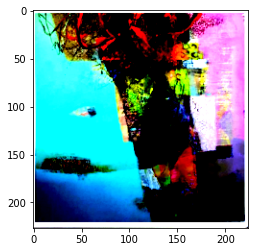

[('indian', 56.360774993896484)]

In [137]:
predict_img("arabic-test.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


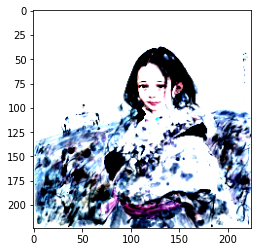

soft tensor([[1.3589e-01, 6.1116e-01, 1.0441e-01, 1.2178e-01, 6.2370e-06, 2.9071e-05,
         7.2738e-06, 2.5215e-05, 2.0878e-05, 3.1447e-06, 2.9233e-06, 1.0425e-05,
         8.2597e-06, 3.2710e-06, 6.6115e-06, 1.0481e-05, 3.2449e-06, 1.7022e-05,
         3.3272e-05, 8.0065e-06, 2.7506e-06, 1.1376e-05, 3.8168e-06, 1.0402e-05,
         4.0740e-05, 1.1531e-05, 2.6656e-05, 8.7349e-06, 2.4406e-05, 4.4219e-06,
         5.4226e-06, 4.5204e-06, 1.0885e-05, 1.6292e-05, 2.1019e-05, 1.9300e-05,
         9.3127e-05, 1.2092e-05, 4.1369e-05, 1.0325e-05, 8.7134e-06, 1.5146e-05,
         5.2649e-06, 8.1483e-06, 2.9500e-06, 1.1259e-05, 4.1359e-06, 6.4288e-06,
         4.7336e-06, 4.5207e-06, 1.4886e-05, 1.8738e-05, 1.2703e-05, 6.7235e-06,
         7.0194e-06, 5.1675e-06, 1.1431e-05, 2.8178e-06, 2.0889e-05, 8.7628e-06,
         2.1298e-05, 3.2340e-05, 2.3083e-05, 2.3443e-05, 1.7292e-05, 1.2953e-05,
         2.2185e-05, 1.6300e-05, 4.9366e-06, 1.1211e-05, 4.3623e-06, 5.6128e-06,
         3.3056e-06, 8.

('Predicted :', 'chinese')

In [121]:
predict_image_class_name('chinese-test.jpg',model) 